In [1]:
from textblob import TextBlob
import re
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize, WhitespaceTokenizer, TweetTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
np.random.seed(18)

In [2]:
df1 = pd.read_csv('train.csv')[['text', 'label']]
df1 = df1[df1.text.isna() == False]
l =len(df1)
print('rows after removing nans: ', l)
rando = list(np.random.choice(l-2, 3000, replace=False))
df1 = df1.iloc[rando]

rows after removing nans:  20761


In [3]:
def calculate_sentiments(dataframe):
    sid = SentimentIntensityAnalyzer()
    scores = [sid.polarity_scores(i) for i in dataframe.text]
    compounds = np.array([i['compound'] for i in scores], dtype='float32')
    abs_compounds = np.array([np.sqrt(i**2) for i in compounds], dtype='float32')
    negs = np.array([i['neg'] for i in scores], dtype='float32')
    neus = np.array([i['neu'] for i in scores], dtype='float32')
    poss = np.array([i['pos'] for i in scores], dtype='float32')
    sent = dataframe['text'].apply(lambda x: TextBlob(x).sentiment)
    pol = np.array([s[0] for s in sent], dtype='float32')
    abs_pol = np.array([np.sqrt(i**2) for i in pol], dtype='float32')
    subj = np.array([s[1] for s in sent], dtype='float32')
    return compounds, abs_compounds, negs, neus, poss, pol, abs_pol, subj
compounds, abs_compounds, negs, neus, poss, pol, abs_pol, subj = calculate_sentiments(df1)

In [4]:
df1['compounds'] = compounds
df1['abs_compounds'] = abs_compounds
df1['negs'] = negs
df1['neus'] = neus
df1['poss'] = poss
df1['pol'] = pol
df1['abs_pol'] = abs_pol
df1['subj'] = subj

In [5]:
#NRC sentiment-emotion lexicon

In [6]:
X = df1[['compounds', 'negs', 'neus', 'poss', 'pol', 'subj']]
y = df1['label']
lrxtrain, lrxtest, lrytrain, lrytest = train_test_split(X, y)
lr = LogisticRegression()
lr.fit(lrxtrain, lrytrain)
lrpreds = lr.predict(lrxtest)
accuracy = accuracy_score(lrytest, lrpreds)
f1 = f1_score(lrytest, lrpreds)
accuracy, f1

(0.5533333333333333, 0.5066273932253315)

In [7]:
def clean_article(article):
    art = re.sub("[^A-Za-z0-9' ]", '', article)
    art2 = re.sub("[( ' )( ')(' )]", ' ', art)
    art3 = re.sub('\s[A-Za-z]\s', ' ', art2)
    return art3.lower()

In [8]:
x_values = df1[['text', 'compounds', 'abs_compounds', 'negs', 'neus', 'poss', 'pol', 'abs_pol', 'subj']]
y_values = df1['label']
xtrain, xtest, ytrain, ytest = train_test_split(x_values, y_values)

In [9]:
%store xtrain
%store xtest
%store ytrain
%store ytest

Stored 'xtrain' (DataFrame)
Stored 'xtest' (DataFrame)
Stored 'ytrain' (Series)
Stored 'ytest' (Series)


In [10]:
bow = CountVectorizer(stop_words = 'english', preprocessor = clean_article, tokenizer = TweetTokenizer().tokenize,
                      ngram_range=(1,2), max_features = 1000, max_df = 1.0, min_df = 1, binary = False)
training_data = bow.fit_transform(xtrain.text)
test_data = bow.transform(xtest.text)

In [11]:
example_article = xtrain.text.iloc[44]
%store example_article 

Stored 'example_article' (str)


In [12]:
ytrain.iloc[44]

1

In [13]:
test_ex = bow.transform(xtrain.text.iloc[44:45])
dfex = pd.DataFrame(test_ex.toarray())
dfex.columns = bow.get_feature_names()
dfex = dfex.drop('s', axis = 1)
dfex['abs_compounds'] = 0
dfex['negs'] = 0
dfex['neus'] = 0
dfex['poss'] = 0
dfex['abs_pol'] = 0
dfex['subj'] = 0
ex = dfex[dfex.columns[(dfex != 0).all()]]
%store ex
%store dfex
dfex

Stored 'ex' (DataFrame)
Stored 'dfex' (DataFrame)


,0,000,1,10,100,11,12,13,15,17,...,york,york times,young,youre,abs_compounds,negs,neus,poss,abs_pol,subj
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
dftrain = pd.DataFrame(training_data.toarray())
dftrain.columns = bow.get_feature_names()
dftrain = dftrain.drop('s', axis = 1)
dftest = pd.DataFrame(test_data.toarray())
dftest.columns = bow.get_feature_names()
dftest = dftest.drop('s', axis = 1)
dftrain.shape

(2250, 999)

In [15]:
lr_plain = LogisticRegression()
model4 = lr_plain.fit(dftrain, ytrain)
lr_plain_preds = model4.predict(dftest)
accuracy = accuracy_score(ytest, lr_plain_preds)
f1 = f1_score(ytest, lr_plain_preds)
accuracy, f1

(0.9213333333333333, 0.9220607661822985)

In [16]:
train_agg = pd.DataFrame.copy(dftrain)
test_agg = pd.DataFrame.copy(dftest)
# testing = train_agg.iloc[33, :]

In [17]:
def find_avg_w(row):
    tally = 0
    rowsum = sum(row)
    for j in range(len(row)):
        tally += len(train_agg.columns[j]) * row[j]
    return tally / rowsum

lista = []
for k in range(train_agg.shape[0]):
    lista.append(find_avg_w(train_agg.iloc[k, : ]))
train_agg['avg_word_length'] = lista

lista = []
for k in range(test_agg.shape[0]):
    lista.append(find_avg_w(test_agg.iloc[k, : ]))
test_agg['avg_word_length'] = lista

#for item in list(train_agg.columns):
   
def find_num_num(row):
    tally = 0
    for j in range(len(row)):
        if train_agg.columns[j].isdigit() == True:
            tally += row[j]
    return tally   
    
lista = []
for k in range(train_agg.shape[0]):        
    lista.append(find_num_num(train_agg.iloc[k, : ]))
train_agg['num_nums'] = lista
lista = []
for k in range(test_agg.shape[0]):        
    lista.append(find_num_num(test_agg.iloc[k, : ]))
test_agg['num_nums'] = lista

ind_train = train_agg.loc[train_agg.avg_word_length.isna() == False].index
ind_test = test_agg.loc[test_agg.avg_word_length.isna() == False].index
train_agg = train_agg[train_agg.avg_word_length.isna() == False]
test_agg = test_agg[test_agg.avg_word_length.isna() == False]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in longlong_scalars
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


In [18]:
train_agg.head()

,0,000,1,10,100,11,12,13,15,17,...,year,years,years ago,yes,york,york times,young,youre,avg_word_length,num_nums
0,0,0,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,5.919355,3.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5.671233,3.0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7.040541,1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,5.527778,0.0
4,0,0,1,0,0,0,0,0,0,0,...,1,1,0,0,4,4,0,0,5.833333,5.0


In [19]:
ytrain_agg = ytrain.reset_index(drop=True)
ytest_agg = ytest.reset_index(drop=True)

In [20]:
ytest_agg = ytest_agg[ind_test]

In [21]:
ytrain_agg = ytrain_agg[ind_train]

In [22]:
lr_agg = LogisticRegression()
model3 = lr_agg.fit(train_agg, ytrain_agg)
lr_agg_preds = model3.predict(test_agg)
accuracy = accuracy_score(ytest_agg, lr_agg_preds)
f1 = f1_score(ytest_agg, lr_agg_preds)
accuracy, f1

(0.9192462987886945, 0.9193548387096774)

In [23]:
df_train_extra = pd.DataFrame.copy(dftrain)
df_train_extra['abs_compounds'] = xtrain['abs_compounds'].values
df_train_extra['negs'] = xtrain['negs'].values
df_train_extra['neus'] = xtrain['neus'].values
df_train_extra['poss'] = xtrain['poss'].values
df_train_extra['abs_pol'] = xtrain['abs_pol'].values
df_train_extra['subj'] = xtrain['subj'].values

df_test_extra = pd.DataFrame.copy(dftest)
df_test_extra['abs_compounds'] = xtest['abs_compounds'].values
df_test_extra['negs'] = xtest['negs'].values
df_test_extra['neus'] = xtest['neus'].values
df_test_extra['poss'] = xtest['poss'].values
df_test_extra['abs_pol'] = xtest['abs_pol'].values
df_test_extra['subj'] = xtest['subj'].values

In [24]:
df_train_lr = pd.DataFrame.copy(dftrain)
df_train_lr['compounds'] = xtrain['compounds'].values
df_train_lr['negs'] = xtrain['negs'].values
df_train_lr['neus'] = xtrain['neus'].values
df_train_lr['poss'] = xtrain['poss'].values
df_train_lr['pol'] = xtrain['pol'].values
df_train_lr['subj'] = xtrain['subj'].values

df_test_lr = pd.DataFrame.copy(dftest)
df_test_lr['compounds'] = xtest['compounds'].values
df_test_lr['negs'] = xtest['negs'].values
df_test_lr['neus'] = xtest['neus'].values
df_test_lr['poss'] = xtest['poss'].values
df_test_lr['pol'] = xtest['pol'].values
df_test_lr['subj'] = xtest['subj'].values
%store df_train_lr

Stored 'df_train_lr' (DataFrame)


In [25]:
df_test_lr.head()

,0,000,1,10,100,11,12,13,15,17,...,york,york times,young,youre,compounds,negs,neus,poss,pol,subj
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,-0.9837,0.085,0.873,0.042,0.026308,0.353579
1,0,0,3,0,0,0,0,0,0,0,...,0,0,0,5,0.9973,0.053,0.832,0.115,0.149236,0.571749
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.6124,0.013,0.934,0.053,-0.005556,0.511111
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,-0.9891,0.154,0.803,0.043,-0.028595,0.329248
4,0,5,3,2,0,0,0,1,1,0,...,0,0,0,0,0.9867,0.065,0.852,0.083,0.054085,0.385309


In [26]:
lr2 = LogisticRegression()
model = lr2.fit(df_train_lr, ytrain)
lr2preds = model.predict(df_test_lr)
accuracy = accuracy_score(ytest, lr2preds)
f1 = f1_score(ytest, lr2preds)
probas = model.predict_log_proba(df_test_lr)
%store model

Stored 'model' (LogisticRegression)


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1356: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))


In [27]:
accuracy, f1

(0.924, 0.924901185770751)

In [28]:
if model.predict(dfex)[0] == 0:
    print("Probably real")
else:
    print("Probably fake")

Probably fake


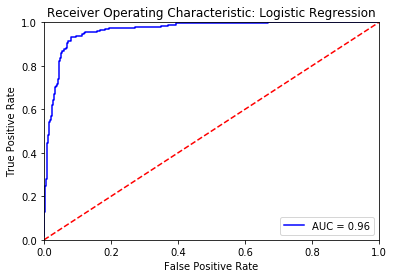

In [29]:
fpr, tpr, threshold = roc_curve(ytest, probas[:,1])  
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic: Logistic Regression')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [30]:
feature_names = np.array(list(train_agg.columns.values))
n=20
coefs_with_fns = sorted(zip(lr_agg.coef_[0], feature_names))
top = list(zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1]))

In [45]:
table1 = pd.DataFrame(columns=['informative for "real"', 'coefficient for "real"', 
                               'informative for "fake"', 'coefficient for "fake"'])
for i in top:
    table1 = table1.append({'informative for "real"': i[0][1], 'coefficient for "real"': i[0][0],
                           'informative for "fake"': i[1][1], 'coefficient for "fake"': i[1][0]}, ignore_index=True)


%store table1
table1



Stored 'table1' (DataFrame)


,"informative for ""real""","coefficient for ""real""","informative for ""fake""","coefficient for ""fake"""
0,000,-1.775681,october,1.464918
1,breitbart,-1.543640,november,1.117678
2,follow,-1.522940,0,1.035245
3,twitter,-1.514925,share,1.005953
4,com,-1.192881,hillary,0.998986
5,sunday,-0.990900,major,0.976374
6,games,-0.948990,2016,0.896866
7,ms,-0.941412,image,0.799001
8,breitbart news,-0.909656,started,0.796570
9,votes,-0.798642,september,0.734943


In [32]:
clf = MultinomialNB()
model_plain_NB = clf.fit(dftrain, ytrain)
preds = model_plain_NB.predict(dftest)

In [33]:
accuracy = accuracy_score(ytest, preds)
f1 = f1_score(ytest, preds)
accuracy, f1

(0.868, 0.8671140939597316)

In [34]:
clf = MultinomialNB()
model_agg = clf.fit(train_agg, ytrain_agg)
preds = model_agg.predict(test_agg)

In [35]:
accuracy = accuracy_score(ytest_agg, preds)
f1 = f1_score(ytest_agg, preds)
accuracy, f1

(0.8882907133243607, 0.8903566710700132)

In [36]:
clf = MultinomialNB()
model2 = clf.fit(df_train_extra, ytrain)
preds = model2.predict(df_test_extra)

In [37]:
accuracy = accuracy_score(ytest, preds)
f1 = f1_score(ytest, preds)
accuracy, f1

(0.8866666666666667, 0.8877146631439893)

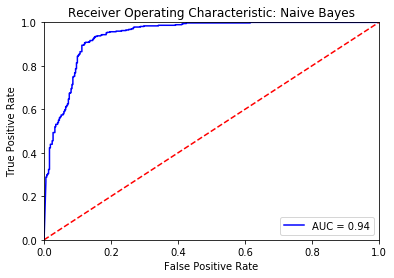

In [38]:
probas2 = model_agg.predict_log_proba(test_agg)
fpr2, tpr2, threshold2 = roc_curve(ytest_agg, probas2[:,1])  
roc_auc2 = auc(fpr2, tpr2)
plt.title('Receiver Operating Characteristic: Naive Bayes')
plt.plot(fpr2, tpr2, 'b', label = 'AUC = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [39]:
feature_names2 = np.array(list(train_agg.columns.values))
#feature_importances = np.argsort(clf.coef_[0])
#feature_names[feature_importances][-20:]

In [40]:
n=20
coefs_with_fns = sorted(zip(model_agg.coef_[0], feature_names2))
top2 = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])

In [46]:
table2 = pd.DataFrame(columns=['informative for "real"', 'coefficient for "real"', 
                               'informative for "fake"', 'coefficient for "fake"'])
for i in top2:
    table2 = table2.append({'informative for "real"': i[0][1], 'coefficient for "real"': i[0][0],
                           'informative for "fake"': i[1][1], 'coefficient for "fake"': i[1][0]}, ignore_index=True)
%store table2

Stored 'table2' (DataFrame)


In [42]:
table2

,"informative for ""real""","coefficient for ""real""","informative for ""fake""","coefficient for ""fake"""
0,000,-10.993878,avg_word_length,-3.350543
1,breitbart news,-10.013048,num_nums,-3.567130
2,mr obama,-10.013048,clinton,-4.614886
3,said mr,-10.013048,trump,-4.644156
4,mr trumps,-9.895265,people,-4.645905
5,com,-9.384440,said,-4.953623
6,games,-9.148051,like,-4.999916
7,pence,-9.148051,hillary,-5.018373
8,president trump,-9.148051,just,-5.061632
9,castro,-9.096758,new,-5.063402
